In [81]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import requests
from io import BytesIO
import statistics
import random
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0

First we will save the file-paths which we will be using in this notebook

In [125]:
main_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus"

Now we will visualize a image at random with its label name to identify how our image looks.
The train_images folder itself contains only the images, but the labels are in the train_images.csv file. In order to have a real training set, the images and labels must be linked together.


In [126]:
train_df = pd.read_csv(os.path.join(main_path, "train_images.csv"))
train_df.head()




,image_path,label
0,/train_images/1.jpg,1
1,/train_images/2.jpg,1
2,/train_images/3.jpg,1
3,/train_images/4.jpg,1
4,/train_images/5.jpg,1


In [127]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3926 entries, 0 to 3925
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3926 non-null   object
 1   label       3926 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 61.5+ KB


In [128]:
from PIL import Image
import os

# Path to your image directory
images_dir = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train_images"

# Set the desired dimensions
required_size = (224, 224)

# Iterate through the image files in the directory
non_standard_images = []
for image_file in os.listdir(images_dir):
    if image_file.endswith((".jpg", ".jpeg", ".png")):  # Ensure it checks image files only
        image_path = os.path.join(images_dir, image_file)
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                if (width, height) != required_size:
                    non_standard_images.append((image_file, width, height))
        except Exception as e:
            print(f"Error opening image {image_file}: {e}")

# Print out non-standard images
if non_standard_images:
    print(f"Images that do not match the size {required_size}:")
    for img in non_standard_images:
        print(f"File: {img[0]}, Size: {img[1]}x{img[2]}")
else:
    print(f"All images are of size {required_size}.")


All images are of size (224, 224).


all images are size 224x224

Preparing the Data

Collecting the labels and mapping the labels to the birds name

In [129]:

# unique() function finds the unique elements
#of an array and returns these unique elements as a sorted array.
# Reverse the dictionary to map labels to class names
label_to_class_name = {v: k for k, v in class_names.items()}

# Map the label column in train_labels to class names
train_labels['class_name'] = train_labels['label'].map(label_to_class_name)

# Clean up the class names by extracting the meaningful part (e.g., after the first '.')
train_labels['class_name'] = train_labels['class_name'].apply(lambda name: name.split('.')[1] if isinstance(name, str) else name)


# Print the DataFrame to verify
print(train_labels.head())



                                     image_path  label              class_name
0  data/data/data/data/data//train_images/1.jpg      1  Black_footed_Albatross
1  data/data/data/data/data//train_images/2.jpg      1  Black_footed_Albatross
2  data/data/data/data/data//train_images/3.jpg      1  Black_footed_Albatross
3  data/data/data/data/data//train_images/4.jpg      1  Black_footed_Albatross
4  data/data/data/data/data//train_images/5.jpg      1  Black_footed_Albatross


In [99]:
labels = train_labels["label"].unique()
bird_name_map = {int(i): train_labels[train_labels["label"] == i]["class_name"].values[0] for i in labels}

print(labels)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]


In [100]:

print(bird_name_map)

{1: 'Black_footed_Albatross', 2: 'Laysan_Albatross', 3: 'Sooty_Albatross', 4: 'Groove_billed_Ani', 5: 'Crested_Auklet', 6: 'Least_Auklet', 7: 'Parakeet_Auklet', 8: 'Rhinoceros_Auklet', 9: 'Brewer_Blackbird', 10: 'Red_winged_Blackbird', 11: 'Rusty_Blackbird', 12: 'Yellow_headed_Blackbird', 13: 'Bobolink', 14: 'Indigo_Bunting', 15: 'Lazuli_Bunting', 16: 'Painted_Bunting', 17: 'Cardinal', 18: 'Spotted_Catbird', 19: 'Gray_Catbird', 20: 'Yellow_breasted_Chat', 21: 'Eastern_Towhee', 22: 'Chuck_will_Widow', 23: 'Brandt_Cormorant', 24: 'Red_faced_Cormorant', 25: 'Pelagic_Cormorant', 26: 'Bronzed_Cowbird', 27: 'Shiny_Cowbird', 28: 'Brown_Creeper', 29: 'American_Crow', 30: 'Fish_Crow', 31: 'Black_billed_Cuckoo', 32: 'Mangrove_Cuckoo', 33: 'Yellow_billed_Cuckoo', 34: 'Gray_crowned_Rosy_Finch', 35: 'Purple_Finch', 36: 'Northern_Flicker', 37: 'Acadian_Flycatcher', 38: 'Great_Crested_Flycatcher', 39: 'Least_Flycatcher', 40: 'Olive_sided_Flycatcher', 41: 'Scissor_tailed_Flycatcher', 42: 'Vermilion_Fl

In [119]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(
    train_labels, 
    test_size=0.2,  # 20% for validation
    stratify=train_df['label'],  # Ensure balanced label distribution
    random_state=42  # For reproducibility
)



AttributeError: 'builtin_function_or_method' object has no attribute 'head'

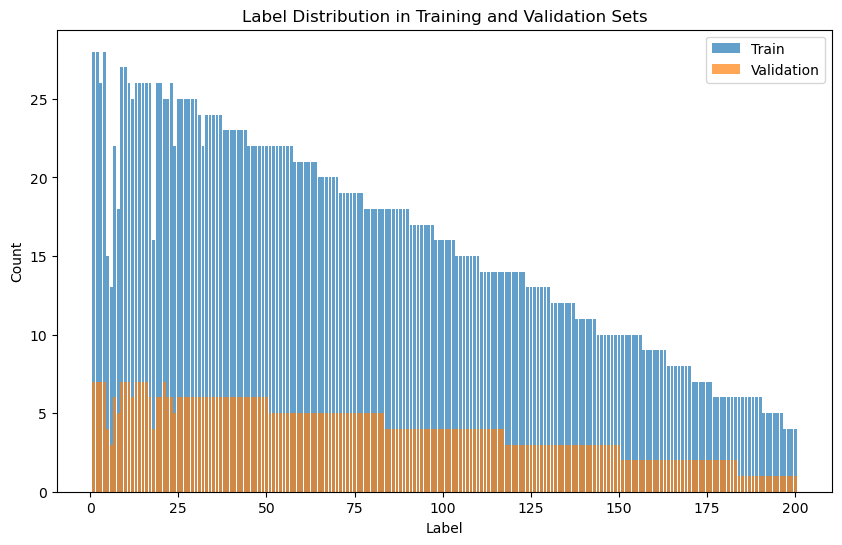

In [109]:
import matplotlib.pyplot as plt

# Get label counts for training and validation sets
train_label_counts = train_data['label'].value_counts()
val_label_counts = val_data['label'].value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training data
ax.bar(train_label_counts.index, train_label_counts.values, label='Train', alpha=0.7)

# Plot validation data
ax.bar(val_label_counts.index, val_label_counts.values, label='Validation', alpha=0.7)
ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.set_title("Label Distribution in Training and Validation Sets")
ax.legend()
plt.show()


In [132]:
# Save the validation set to a CSV file
validation_output_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/validation_data.csv"  # Specify file name
val_data.to_csv(validation_output_path, index=False)

# Print confirmation
print(f"Validation data saved to {validation_output_path}")


Validation data saved to /Users/bognarlili/Downloads/aml-2024-feather-in-focus/validation_data.csv


In [123]:
test_df = pd.read_csv(os.path.join(main_path, "test_images_path.csv"))
test_df.head()

,id,image_path,label
0,1,/test_images/999.jpg,1
1,2,/test_images/998.jpg,1
2,3,/test_images/997.jpg,1
3,4,/test_images/996.jpg,1
4,5,/test_images/995.jpg,1


In [204]:

# unique() function finds the unique elements
#of an array and returns these unique elements as a sorted array.
# Reverse the dictionary to map labels to class names
label_to_class_name = {v: k for k, v in class_names.items()}

# Map the label column in train_labels to class names
test_labels['class_name'] = test_labels['label'].map(label_to_class_name)

# Clean up the class names by extracting the meaningful part (e.g., after the first '.')
test_labels['class_name'] = test_labels['class_name'].apply(lambda name: name.split('.')[1] if isinstance(name, str) else name)


# Print the DataFrame to verify
print(train_labels.head())


                                     image_path  label              class_name
0  data/data/data/data/data//train_images/1.jpg      1  Black_footed_Albatross
1  data/data/data/data/data//train_images/2.jpg      1  Black_footed_Albatross
2  data/data/data/data/data//train_images/3.jpg      1  Black_footed_Albatross
3  data/data/data/data/data//train_images/4.jpg      1  Black_footed_Albatross
4  data/data/data/data/data//train_images/5.jpg      1  Black_footed_Albatross


In [205]:
# Define output paths for train, validation, and test data
train_output_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train_data.csv"
validation_output_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/validation_data.csv"
test_output_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/test_data.csv"

# Save the train, validation, and test datasets to CSV files
train_data.to_csv(train_output_path, index=False)
val_data.to_csv(validation_output_path, index=False)
test_labels.to_csv(test_output_path, index=False)

# Print confirmation for each
print(f"Train data saved to {train_output_path}")
print(f"Validation data saved to {validation_output_path}")
print(f"Test data saved to {test_output_path}")


Train data saved to /Users/bognarlili/Downloads/aml-2024-feather-in-focus/train_data.csv
Validation data saved to /Users/bognarlili/Downloads/aml-2024-feather-in-focus/validation_data.csv
Test data saved to /Users/bognarlili/Downloads/aml-2024-feather-in-focus/test_data.csv


In [206]:

train = os.path.join(main_path,'train')
test = os.path.join(main_path,'test')
valid = os.path.join(main_path,'valid')

## Visulalize the images
Now we will visualize a image at random with its label name to identify how our image looks

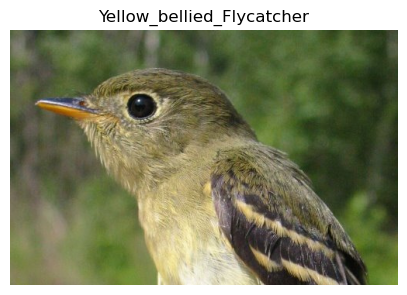

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import random
import os

# Path to your CSV file
csv_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_data.csv"
# Path to your train images folder
image_folder = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images"

# Read the CSV
train_data = pd.read_csv(csv_path)

# Randomly select a row from the dataframe
random_entry = train_data.sample(n=1).iloc[0]

# Extract the image path and label
image_name = random_entry['image_path']  # Full image path
label = random_entry['class_name']  # Class name

# Combine the folder path with the image path
image_path = os.path.join(image_folder, os.path.basename(image_name))

# Verify if the image exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at path: {image_path}")


img = mimg.imread(image_path)
plt.figure(figsize=(5, 5))
plt.title(label)  
plt.axis('off')
plt.imshow(img)
plt.show()


## Checking distribution of images in each class
Now we will check the distributuon of images across different classes, it is necessary because if images are not distributed evenly across the classes, there might be chances that our model can underfit or overfit on the data.

In [239]:
import pandas as pd
import os
import statistics

# Define paths
csv_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train_data.csv"  # Path to train_data.csv

# Read the CSV file
train_data = pd.read_csv(csv_path)

# Initialize a dictionary to store species and their image counts
store_species_count = {}

# Count the number of images per species
for species in train_data['class_name'].unique():
    count_imgs = train_data[train_data['class_name'] == species].shape[0]
    store_species_count[species] = count_imgs

# Find the species with the minimum number of images
min_key, min_value = min(store_species_count.items(), key=lambda x: x[1])

# Find the species with the maximum number of images
max_key, max_value = max(store_species_count.items(), key=lambda x: x[1])

# Get a list of the image counts
values_list = list(store_species_count.values())

# Compute the median value of image counts
median_value = statistics.median(values_list)

# Print the results
print("Minimum count of images in a class:", min_value, "corresponding Species:", min_key)
print("Maximum count of images in a class:", max_value, "corresponding Species:", max_key)
print("Median value:", median_value, "images")


Minimum count of images in a class: 4 corresponding Species: Winter_Wren
Maximum count of images in a class: 28 corresponding Species: Black_footed_Albatross
Median value: 16.0 images


## Categorizing the images
Here we are using Tensorflows ImageDataGenerator function this function takes image directory path. preprocess the image and stratify the count of images in each class such that each class has same number of images for model training.

In [291]:
# preprocessing the image and storing it under appropriate labels

train_gen = ImageDataGenerator(width_shift_range = 0.5,
                              height_shift_range = 0.5)

train_set = train_gen.flow_from_directory(train,target_size = (224,224),class_mode = 'categorical',batch_size = 32)

Found 3926 images belonging to 201 classes.


In [292]:
# geting the labels from training data, it will be later used to predict the class when an image is passed

labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
len(labels)

201

Below we see that we are not preprocessing test and validation data, its because we will be using this images to see how well our model predicts.

In [293]:
import os
import shutil
import pandas as pd

# Adatok betöltése
csv_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_data.csv"  # Add meg a CSV fájl útvonalát
data = pd.read_csv(csv_path)

# Fő mappa, ahol a képek vannak
source_folder = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_images/test_images"  # A képeid jelenlegi helye
destination_folder = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_images/test_images"  # Új mappa, amely az osztályokat tartalmazza

# Ha a célmappa nem létezik, hozzuk létre
os.makedirs(destination_folder, exist_ok=True)

# Minden sor alapján létrehozzuk a mappákat és áthelyezzük a képeket
for _, row in data.iterrows():
    image_path = os.path.join(source_folder, os.path.basename(row['image_path']))
    class_name = row['class_name']
    class_folder = os.path.join(destination_folder, class_name)

    # Létrehozzuk az osztályhoz tartozó almappát, ha még nem létezik
    os.makedirs(class_folder, exist_ok=True)

    # Kép áthelyezése az osztály mappájába
    try:
        shutil.move(image_path, os.path.join(class_folder, os.path.basename(image_path)))
    except FileNotFoundError:
        print(f"Nem található a kép: {image_path}")

print("Fájlok áthelyezése befejeződött.")


Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_images/test_images/999.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_images/test_images/998.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_images/test_images/997.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_images/test_images/996.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_images/test_images/995.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_images/test_images/994.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_images/test_images/993.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_images/test_images/992.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/test/test_images/test_images/

In [294]:
# Getting data for testing
test_gen = ImageDataGenerator()

test_set = test_gen.flow_from_directory(destination_folder,target_size = (224,224),class_mode = 'categorical',batch_size = 32)

Found 4000 images belonging to 200 classes.


In [295]:
import os
import shutil
import pandas as pd

# Adatok betöltése
csv_valid_path = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/validation_data.csv"  # Add meg a CSV fájl útvonalát
data = pd.read_csv(csv_valid_path)

# Fő mappa, ahol a képek vannak
source_folder = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images"  # A képeid jelenlegi helye
destination_folder = "/Users/bognarlili/Downloads/aml-2024-feather-in-focus/train"  # Új mappa, amely az osztályokat tartalmazza

# Ha a célmappa nem létezik, hozzuk létre
os.makedirs(destination_folder, exist_ok=True)

# Minden sor alapján létrehozzuk a mappákat és áthelyezzük a képeket
for _, row in data.iterrows():
    image_path = os.path.join(source_folder, os.path.basename(row['image_path']))
    class_name = row['class_name']
    class_folder = os.path.join(destination_folder, class_name)

    # Létrehozzuk az osztályhoz tartozó almappát, ha még nem létezik
    os.makedirs(class_folder, exist_ok=True)

    # Kép áthelyezése az osztály mappájába
    try:
        shutil.move(image_path, os.path.join(class_folder, os.path.basename(image_path)))
    except FileNotFoundError:
        print(f"Nem található a kép: {image_path}")

print("Fájlok áthelyezése befejeződött.")


Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images/2005.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images/1712.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images/2253.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images/748.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images/2347.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images/3093.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images/605.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus/train/train_images/train_images/3153.jpg
Nem található a kép: /Users/bognarlili/Downloads/aml-2024-feather-in-focus

In [296]:
# getting data for validation
valid_gen = ImageDataGenerator()

valid_set = valid_gen.flow_from_directory(destination_folder,target_size = (224,224),class_mode = 'categorical',batch_size = 32)


Found 3926 images belonging to 201 classes.


## Creating our model
Now we are ready with our data lets start building our image classifier model, for that first we need to get EfficientNetB0 model from Tensorfow Keras API, more about EfficientNetB0 can be found here https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0

Below we can also see that we are setting the layers of our EfficientNetB0 to False, its because this model has already been trained on larger set of image data and we are using it classify our birds species, also if we want we can set layers to true, but it will consume more time in training our model.

In [297]:
# Downloading the pre-trained model from API
eff_net_model = EfficientNetB0(
                    include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='max',
                    classes=len(labels)
                )

# setting all the layers of this model to false
for layer in eff_net_model.layers:
    layer.trainable = False

After we download EfficientNetB0, We are adding custom dense layers to the model so that our model can classify images based on 525 diffent labels.

In [298]:
model = Sequential()
model.add(eff_net_model)
model.add(Dense(2560,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1280,activation='relu'))
model.add(Dense(len(labels),activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2560)           │     3,279,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1280)           │     3,278,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 201)            │       257,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,874,732 (41.48 MB)

 Trainable params: 6,820,041 (26.02 MB)

 Non-trainable params: 4,054,691 (15.47 MB)


Now we will its time to select our optimizer for our model, Adam Optimizer is the best optimizer for our use case as it has better optimization and faster compuation time, we can also set learnign rate for our optimizer, I have used 0.00001 as my learning_rate value, this is the best learning rate value for our use-case.

In [299]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [309]:
modelcheck_lr = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/bognarlili/Downloads/final_model.keras',  # Használj .keras kiterjesztést
    monitor='val_loss',
    save_best_only=True
)


## Training the Model
Now we have built our model and specified required optimizer and callbacks, its time to train our model and visualize the training results

In [310]:
model_hist = model.fit(train_set,validation_data = valid_set,epochs = 20,callbacks = [modelcheck_lr,early])


Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 114s 928ms/step - accuracy: 0.8027 - loss: 1.7027 - val_accuracy: 0.7998 - val_loss: 1.5096
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 118s 964ms/step - accuracy: 0.7980 - loss: 1.5503 - val_accuracy: 0.7998 - val_loss: 1.4123
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 119s 972ms/step - accuracy: 0.7991 - loss: 1.4672 - val_accuracy: 0.8001 - val_loss: 1.3302
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.8051 - loss: 1.3653 - val_accuracy: 0.8008 - val_loss: 1.2494
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 116s 941ms/step - accuracy: 0.8043 - loss: 1.2903 - val_accuracy: 0.8001 - val_loss: 1.1794
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 111s 906ms/step - accuracy: 0.7818 - loss: 1.3435 - val_accuracy: 0.8001 - val_loss: 1.1129
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.8013 - loss: 1.1916 - val_accuracy: 0.8016 - val_loss: 1.0553
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.7992 - loss: 1.

In [311]:
 #Visualizing the result 
acc = model_hist.history['accuracy']
val_acc = model_hist.history['val_accuracy']
loss = model_hist.history['loss']
val_loss = model_hist.history['val_loss']

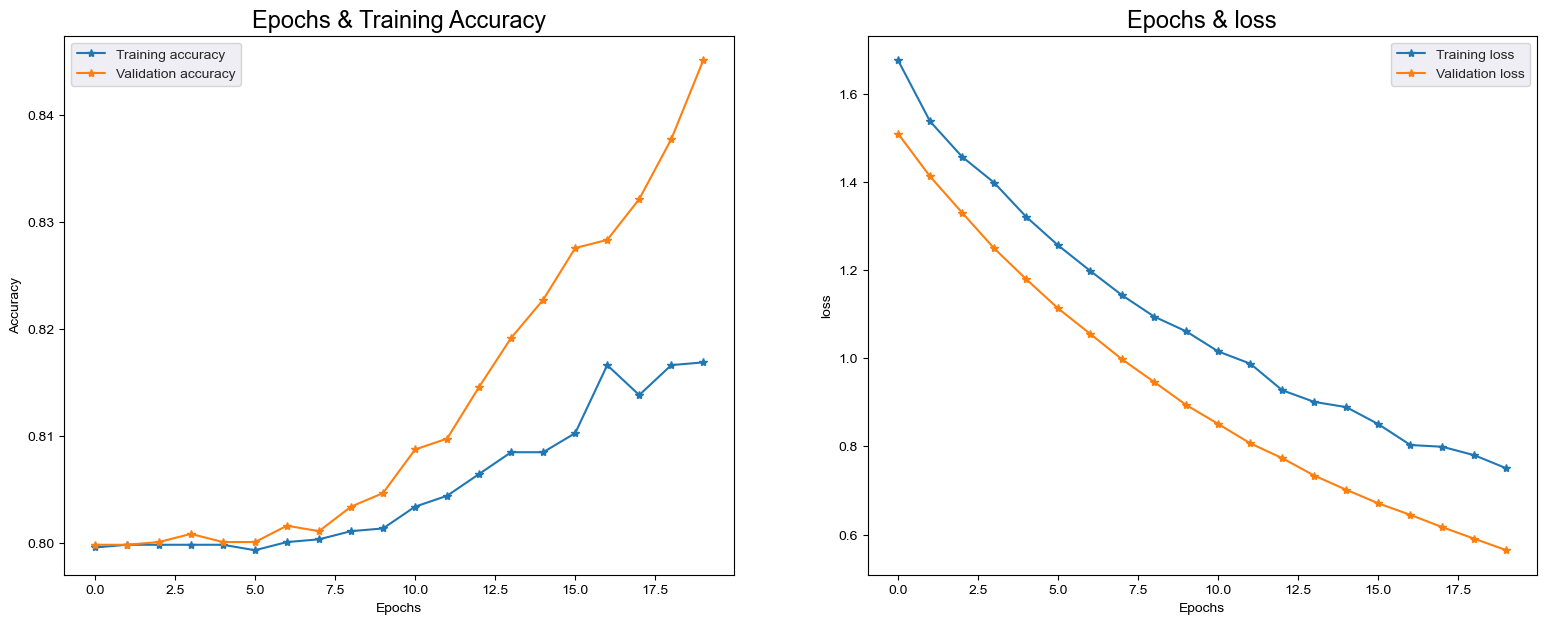

In [312]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, '*-',label = 'Training accuracy')
ax[0].plot(val_acc, '*-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, '*-',label = 'Training loss')
ax[1].plot(val_loss, '*-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

In [313]:
# load and evaluate best model
model.load_weights('/kaggle/working/final_model.h5')
eval_data = model.evaluate(test_set)
print("Validation Loss :",eval_data[0])
print("Validation Accuracy :",eval_data[1])

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/kaggle/working/final_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)